In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
file = '/Users/zhaoxu/Library/CloudStorage/GoogleDrive-xu.zhao@york.ac.uk/My Drive/2.3- Code/Jupyter/PyHelios/testdata/130PP-15J-2ns.exo'
data = xr.open_dataset(file)

In [9]:
time = data['time_whole'].values 
radius = data['zone_boundaries'].values * 1e4
density = data['mass_density'].values  
ElecTemp = data['elec_temperature'].values 

In [11]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [10]:
time

array([1.000000e-15, 1.000000e-11, 2.000000e-11, 3.000000e-11,
       4.000000e-11, 5.000000e-11, 6.000000e-11, 7.000000e-11,
       8.000000e-11, 9.000000e-11, 1.000000e-10, 1.100000e-10,
       1.200000e-10, 1.300000e-10, 1.400000e-10, 1.500000e-10,
       1.600000e-10, 1.700000e-10, 1.800000e-10, 1.900000e-10,
       2.000000e-10, 2.100000e-10, 2.200000e-10, 2.300000e-10,
       2.400000e-10, 2.500000e-10, 2.600000e-10, 2.700000e-10,
       2.800000e-10, 2.900000e-10, 3.000000e-10, 3.100000e-10,
       3.200000e-10, 3.300000e-10, 3.400000e-10, 3.500000e-10,
       3.600000e-10, 3.700000e-10, 3.800000e-10, 3.900000e-10,
       4.000000e-10, 4.100000e-10, 4.200000e-10, 4.300000e-10,
       4.400000e-10, 4.500000e-10, 4.600000e-10, 4.700000e-10,
       4.800000e-10, 4.900000e-10, 5.000000e-10, 5.100000e-10,
       5.200000e-10, 5.300000e-10, 5.400000e-10, 5.500000e-10,
       5.600000e-10, 5.700000e-10, 5.800000e-10, 5.900000e-10,
       6.000000e-10, 6.100000e-10, 6.200000e-10, 6.3000

In [7]:
print(time.shape)
print(radius.shape)
print(density.shape)

(502,)
(502, 201)
(502, 200)


In [44]:
density.shape

(502, 200)

In [45]:
radius_diff = np.diff(radius, axis=0) / 2
radius_edges = np.vstack((radius[0, :] - radius_diff[0, :],
                          radius[:-1, :] + radius_diff,
                          radius[-1, :] + radius_diff[-1, :]))
radius_edges.shape

(503, 201)

In [46]:
time_diff = np.diff(time) / 2
time_edges = np.concatenate(([time[0] - time_diff[0]], time[:-1] + time_diff, [time[-1] + time_diff[-1]]))
time_edges.shape

(503,)

In [54]:
print(density.T.shape)
print(radius_edges.T.shape)
print(time_edges.shape)

(200, 502)
(201, 503)
(503,)


(-20.0, 100.0)

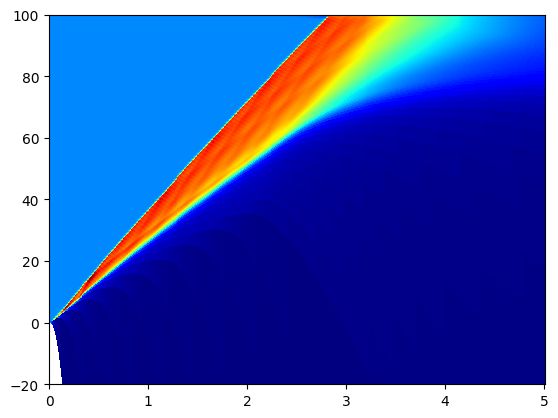

In [79]:
plt.pcolormesh(time_edges,radius_edges.T, density.T, shading='auto', cmap='jet',
               )
plt.ylim(-20, 100)

/var/folders/8x/8b_22rcx3qvdx_26x022tzbw0000gn/T/ipykernel_62479/3233196070.py:61: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = plt.pcolormesh(T_mesh, R_mesh, rho, shading='auto', cmap='jet')


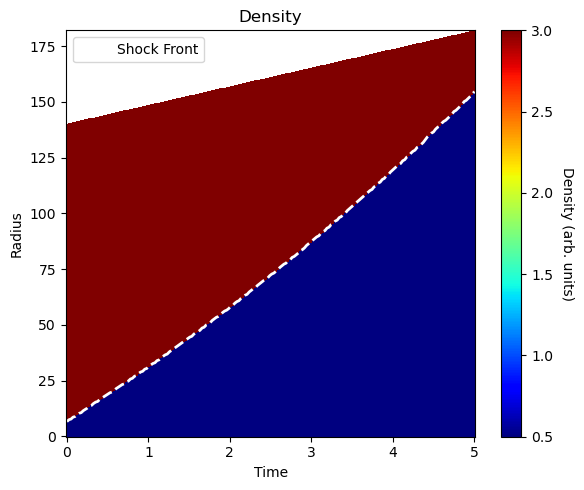

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# —— 假设你已经把真实模拟数据读到以下三个数组中 —— 
# t:   shape (ntime,)  的时间向量
# r:   shape (ntime, ncell)  的 Lagrange 网格位置
# rho: shape (ntime, ncell)  的密度数据

# 这里简单用示例数据代替，你在自己程序里改成加载真实数据即可：
ntime = 200
ncell = 500
t = np.linspace(0, 5, ntime)

# 构造一个“随时间膨胀的线性网格”，仅示范
r = np.zeros((ntime, ncell))
for j in range(ntime):
    r[j, :] = np.linspace(0, 140, ncell) * (1 + 0.3 * j/ntime)

# 构造一个“随时间向外推进的密度跳变”
rho = np.ones((ntime, ncell)) * 0.5
for j in range(ntime):
    pos_idx = int((ncell-1)*(0.05 + 0.8 * j/(ntime-1)))
    rho[j, pos_idx:] = 3.0

# —— 1. 计算每个时间步的“精确冲击位置” —— 
r_shock = np.zeros(ntime)
for j in range(ntime):
    r_j, rho_j = r[j, :], rho[j, :]

    # （1）平滑一下：这里用 3 点滑动平均再求梯度，减少数值振荡的影响
    window = 3
    rho_smooth = np.convolve(rho_j, np.ones(window)/window, mode='same')

    # （2）计算 drho/dr
    drho_dr = np.gradient(rho_smooth, r_j)

    # （3）找出“正向最大斜率”位置
    i0 = np.argmax(drho_dr)

    # （4）用“节点中点插值”修正：
    if i0 < ncell-1:
        # 左右节点
        r_left,  rho_left  = r_j[i0],   rho_j[i0]
        r_right, rho_right = r_j[i0+1], rho_j[i0+1]
        # 直接取中点
        # —— 如果你想用 '(rho_left + rho_right)/2' 作为阈值，再做线性插值，也可以：
        #   frac = ((rho_left+rho_right)/2 - rho_left) / (rho_right - rho_left)
        #   r_interp = r_left + frac * (r_right - r_left)
        r_interp = 0.5*(r_left + r_right)
    else:
        # 万一 i0 已经是最后一个节点，就直接用最后节点：
        r_interp = r_j[i0]

    r_shock[j] = r_interp

# —— 2. 用 pcolormesh 在“真实网格”上画出密度 + 叠加冲击线 —— 
T_mesh = np.tile(t.reshape(-1,1), (1, ncell))  # shape (ntime, ncell)
R_mesh = r.copy()                              # shape (ntime, ncell)

plt.figure(figsize=(6,5))
pcm = plt.pcolormesh(T_mesh, R_mesh, rho, shading='auto', cmap='jet')
cbar = plt.colorbar(pcm)
cbar.set_label('Density (arb. units)', rotation=270, labelpad=15)

plt.plot(t, r_shock, 'w--', linewidth=2, label='Shock Front')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Density')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()